In [44]:
import warnings
warnings.filterwarnings("ignore")

#!pip3 install plotly.express
#import sys
#!conda install --yes --prefix {sys.prefix} plotly
#!conda install -c anaconda py-xgboost --yes
#!pip3 install hyperopt
# !conda install -c conda-forge hyperopt --yes
#sudo apt-get install graphviz

!conda install -c anaconda graphviz --yes
!pip3 install graphviz

!conda install graphviz python-graphviz --yes




Solving environment: done

# All requested packages already installed.

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Solving environment: done

## Package Plan ##

  environment location: /Users/Vaibhav_Beohar/anaconda3

  added / updated specs:
    - graphviz
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.1.1   |                0         125 KB
    certifi-2019.11.28         |           py37_0         153 KB
    conda-4.8.3                |           py37_0         2.8 MB
    openssl-1.1.1d             |       h1de35cc_4         2.2 MB
    python-graphviz-0.13.2     |             py_0          24 KB
    ------------------------

### Import Packages and define functions

In [179]:
import multiprocessing as mp
import os

import numpy as np
from numpy import sort

import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
sns.set_context('notebook')
sns.set_style('white')
%matplotlib inline

#import utils
from ipywidgets import interact, fixed


from sklearn.svm import LinearSVR, SVR
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import Ridge
from sklearn import linear_model
from scipy import stats
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss

np.random.seed(0)

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error 

from sklearn.feature_selection import SelectFromModel


### EDA and Feature Engineering

In [180]:
# load csv
df = pd.read_csv('train_cleaned.csv',index_col=0)
df.head()

,log_price,property_type,room_type,amenities,internet,air_conditioning,breakfast,parking,kitchen,pool,pets_allowed,checkin_24,tv,laundry,accommodates,bathrooms,bed_type,cancellation_policy,flexible,moderate,strict,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,miles_city_center,cc_latitude,cc_longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,has_thumbnail,zipcode,bedrooms,beds
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",1,1,0,0,1,0,0,0,0,0,3,1.0,Real Bed,strict,0,0,1,1,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",6/18/2016,1.0,1.0,NaN,3/26/2012,0,7/18/2016,40.696524,-73.991617,2.708,40.712743,-74.013380,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,1,11201.0,1.0,1.0
6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",1,1,0,0,1,0,0,0,0,1,7,1.0,Real Bed,strict,0,0,1,1,NYC,Enjoy travelling during your stay in Manhattan...,8/5/2017,1.0,0.0,100%,6/19/2017,1,9/23/2017,40.766115,-73.989040,5.882,40.712743,-74.013380,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,1,10019.0,3.0,3.0
7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",1,1,1,0,1,0,0,0,1,0,5,1.0,Real Bed,moderate,0,1,0,1,NYC,The Oasis comes complete with a full backyard ...,4/30/2017,1.0,1.0,100%,10/25/2016,1,9/14/2017,40.808110,-73.943756,11.837,40.712743,-74.013380,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,1,10027.0,1.0,3.0
13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",1,0,0,0,1,0,0,0,1,1,4,1.0,Real Bed,flexible,1,0,0,1,SF,This light-filled home-away-from-home is super...,NaN,1.0,1.0,NaN,4/19/2015,0,NaN,37.772004,-122.431619,3.707,37.795211,-122.402779,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,1,94117.0,2.0,2.0
3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",1,1,0,0,1,0,0,0,1,0,2,1.0,Real Bed,moderate,0,1,0,1,DC,"Cool, cozy, and comfortable studio located in ...",5/12/2015,1.0,1.0,100%,3/1/2015,1,1/22/2017,38.925627,-77.034596,2.800,38.897743,-77.036530,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,0,20009.0,0.0,1.0


In [182]:
# create dummies for some variables that should have them
df2 = pd.get_dummies(data=df, columns = ['city', 'room_type', 'property_type'])

# grab the new dummies
df2 = df2.iloc[:, 43::]

df.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
df2.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)

# print(df2.head())

In [225]:
# concat into CSV DF
df = pd.concat([df, df2], axis = 1)

# remove string vars
df = df.select_dtypes(exclude=[np.object])

# drop na
df = df.dropna(axis = 0)

# prepare X, y
y = df['log_price'].values
X_cols = list(df.columns)
X_cols.pop(0)

X = df.drop(['log_price'], axis = 1).values


# shuffle data
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, y = X[shuffle], y[shuffle]

# split data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state = 42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_full, y_train_full, random_state = 42)

print(y_dev.shape)
print('X_cols', len(X_cols))
print(X_cols)

(10037,)
X_cols 374
['internet', 'air_conditioning', 'breakfast', 'parking', 'kitchen', 'pool', 'pets_allowed', 'checkin_24', 'tv', 'laundry', 'accommodates', 'bathrooms', 'flexible', 'moderate', 'strict', 'cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'latitude', 'longitude', 'miles_city_center', 'cc_latitude', 'cc_longitude', 'number_of_reviews', 'review_scores_rating', 'has_thumbnail', 'zipcode', 'bedrooms', 'beds', 'city_Chicago', 'city_DC', 'city_LA', 'city_NYC', 'city_SF', 'room_type_Entire_home/apt', 'room_type_Private_room', 'room_type_Shared_room', 'property_type_Apartment', 'property_type_Bed_&_Breakfast', 'property_type_Boat', 'property_type_Boutique_hotel', 'property_type_Bungalow', 'property_type_Cabin', 'property_type_Camper/RV', 'property_type_Casa_particular', 'property_type_Castle', 'property_type_Cave', 'property_type_Chalet', 'property_type_Condominium', 'property_type_Dorm', 'property_type_Earth_House', 'property_type_Guest_sui

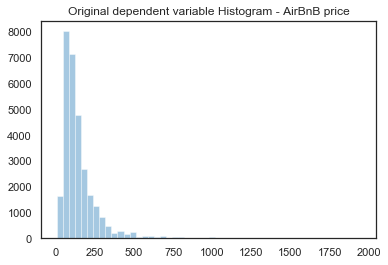

In [184]:
sns.distplot(np.exp(y_train), kde=False)
plt.title('Original dependent variable Histogram - AirBnB price');

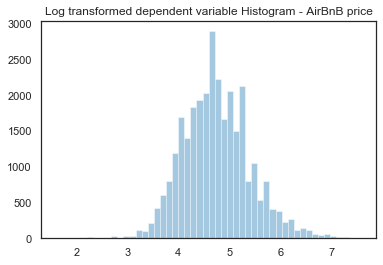

In [185]:
sns.distplot(y_train, kde=False)
plt.title('Log transformed dependent variable Histogram - AirBnB price');

### Nominal Variables

In [186]:
nominal = ['internet','air_conditioning','breakfast','parking','kitchen','pool','pets_allowed',
           'checkin_24','tv','laundry','accommodates','bathrooms','flexible','moderate','strict',
           'cleaning_fee','host_has_profile_pic','host_identity_verified','instant_bookable','longitude',
           'miles_city_center','cc_latitude','cc_longitude','number_of_reviews','review_scores_rating',
           'bedrooms','beds']

df_quant = df[nominal]

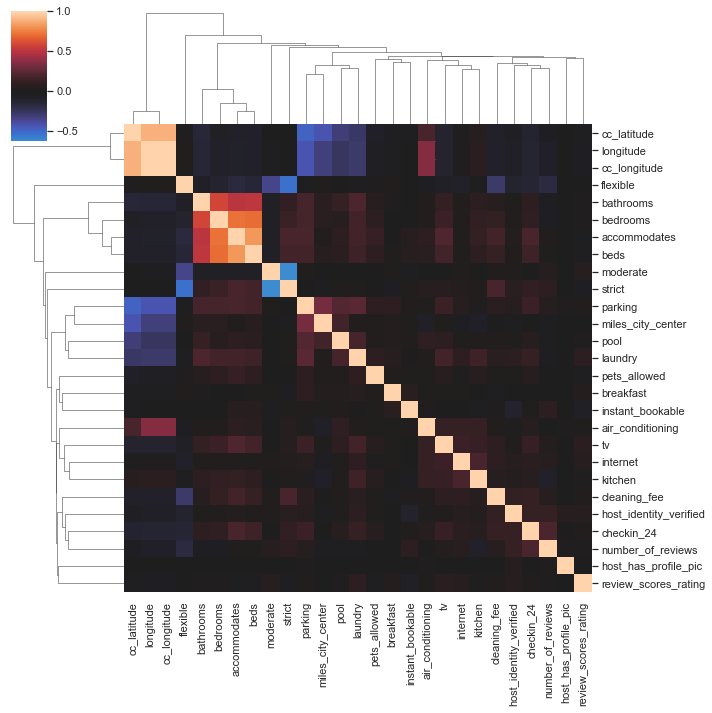

In [187]:
sns.clustermap(df_quant.corr(), center=0)

### Modeling

In [188]:

# scorer
mse = make_scorer(metrics.mean_squared_error)

# functions
# confidence interval
def confidence_interval(confidence_level, predicted_y, y_test):
    confidence = confidence_level
    squared_errors = (predicted_y - y_test) ** 2
    return np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                             loc = squared_errors.mean(),
                             scale = stats.sem(squared_errors)))

# cross val scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", round(scores.mean(), 3))
    print("Standard deviation:", round(scores.std(), 3))


# result storage
model_name = []
RMSE = []
CI = []
cross_val_mean = []

In [169]:

################## Base Model: Linear Regression ##################
# fit a linear regression model
lm = LinearRegression() # instantiate lm
lm.fit(X_train_full, y_train_full); # fit lm
r2_lm = lm.score(X_train_full, y_train_full) # x, y

# show r2 of regression model
print(round(r2_lm, 3), 'is the r-squared for the regression model')

# generate predictions
predicted_y = lm.predict(X_test) # prediction

# metrics
lm_RMSE = mean_squared_error(y_test, predicted_y, squared = False)
print('Root Mean Squared Error:', round(lm_RMSE, 3))

# confidence interval for RMSE
lm_ci = confidence_interval(0.95, predicted_y, y_test)
print('The 95% confidence interval for our RMSE is:', np.round(lm_ci, 3))

# cross-val on dev data
scores = cross_val_score(lm, X_dev, y_dev,
                         scoring = "neg_mean_squared_error", # expects utility fx
                         cv = 10) # 10 folds

rmse_scores = np.sqrt(-scores) # sqrt for RMSE

display_scores(rmse_scores)
# dev data contains some very messed up observations,
# or lm is just struggling to predict,
# as evidenced by cross-val

display_scores(rmse_scores)

# append results
model_name.append('linear model')
RMSE.append(lm_RMSE)
CI.append(lm_ci)
cross_val_mean.append(rmse_scores.mean())

0.663 is the r-squared for the regression model
Root Mean Squared Error: 0.381
The 95% confidence interval for our RMSE is: [0.374 0.387]
Scores: [0.38711925 0.38105801 0.38384291 0.39502018 0.36974067 0.40851729
 0.38387248 0.38465918 0.38743473 0.38689151]
Mean: 0.387
Standard deviation: 0.009
Scores: [0.38711925 0.38105801 0.38384291 0.39502018 0.36974067 0.40851729
 0.38387248 0.38465918 0.38743473 0.38689151]
Mean: 0.387
Standard deviation: 0.009


### HyperOpt parameterization for XGBoost https://mlwhiz.com/blog/2017/12/28/hyperopt_tuning_ml_model/

In [33]:
def objective(space):
    print(space)
    clf = xgb.XGBRegressor(n_estimators =1000, 
                            colsample_bytree=space['colsample_bytree'],
                            learning_rate = 0.1, #space['learning_rate'],
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            n_jobs=8,
                            gamma = space['gamma'],
                            reg_lambda = space['reg_lambda'],
                            #objective = 'reg:squarederror',
                            objective = 'reg:squarederror')
                           

    eval_set  = [( X_train_full, y_train_full), ( X_dev, y_dev)]

    clf.fit(X_train_full, y_train_full,
            eval_set=eval_set,
            eval_metric="rmse",
            early_stopping_rounds=10,
            #eval_metric="mlogloss",
            verbose=False)

    pred = clf.predict(X_dev)
    #pred_prob = clf.predict_proba(X_dev)
    
    mse_scr = mean_squared_error(y_dev, pred)
    #loss = log_loss(y_dev, pred_prob)    

    print ("SCORE:", np.sqrt(mse_scr))
    #print ("SCORE:", loss)
    #change the metric if you like
    return {'loss': mse_scr, 'status': STATUS_OK , 'model': clf}


space ={'max_depth': hp.quniform("x_max_depth", 4, 16, 1),
         'min_child_weight': hp.quniform ('x_min_child', 1, 12, 1),
         'subsample': hp.uniform ('x_subsample', 0.7, 1),
         'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
         'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.7,1),
         'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1)
         #'learning_rate' : hp.uniform ('x_learning_rate', 0.01,1.0)
       }


trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best XGB model parameters are", best)

{'colsample_bytree': 0.7772910970832447, 'gamma': 0.15453272251064917, 'max_depth': 14.0, 'min_child_weight': 7.0, 'reg_lambda': 0.5988880458786856, 'subsample': 0.8159555174991628}
SCORE:                                                
0.12881417025656572                                   
{'colsample_bytree': 0.8855675098244062, 'gamma': 0.11266333248238732, 'max_depth': 14.0, 'min_child_weight': 3.0, 'reg_lambda': 0.6819701503912113, 'subsample': 0.8442955970717686}
SCORE:                                                                            
0.10867717819784344                                                               
{'colsample_bytree': 0.7753703033635937, 'gamma': 0.2249895047798568, 'max_depth': 14.0, 'min_child_weight': 12.0, 'reg_lambda': 0.30729071643857164, 'subsample': 0.8598963467198852}
SCORE:                                                                            
0.15953111237983758                                                               
{'colsample

SCORE:                                                                            
0.14513414788334436                                                               
{'colsample_bytree': 0.9821544476241204, 'gamma': 0.1592346222493948, 'max_depth': 16.0, 'min_child_weight': 2.0, 'reg_lambda': 0.8747247564284195, 'subsample': 0.9024298101097036}
SCORE:                                                                            
0.12501262941144964                                                               
{'colsample_bytree': 0.9251267762221372, 'gamma': 0.19796024500471826, 'max_depth': 16.0, 'min_child_weight': 2.0, 'reg_lambda': 0.9005548953321854, 'subsample': 0.9984570029650303}
SCORE:                                                                            
0.1685117659123887                                                                
{'colsample_bytree': 0.9686477270015135, 'gamma': 0.2560955311279063, 'max_depth': 15.0, 'min_child_weight': 4.0, 'reg_lambda': 0.767409806

{'colsample_bytree': 0.7310208816746981, 'gamma': 0.17063151306081384, 'max_depth': 14.0, 'min_child_weight': 11.0, 'reg_lambda': 0.6264013325728528, 'subsample': 0.9195917339061602}
SCORE:                                                                             
0.14865593496512203                                                                
{'colsample_bytree': 0.956625361184157, 'gamma': 0.23708232729795314, 'max_depth': 13.0, 'min_child_weight': 1.0, 'reg_lambda': 0.3660269538243805, 'subsample': 0.8355687338318305}
SCORE:                                                                             
0.1529032955358949                                                                 
{'colsample_bytree': 0.8503144824481802, 'gamma': 0.34724774153391946, 'max_depth': 11.0, 'min_child_weight': 9.0, 'reg_lambda': 0.17383119171652156, 'subsample': 0.7720125304035022}
SCORE:                                                                             
0.19092235391239334              

### Optimized XGBoost with Hyperparameters obtained from Hyperopt

### Baseline XGBoost Model and Performance

In [192]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
# import graphviz
# from graphviz import Digraph

xgtrain = xgb.DMatrix(X_train_full, label=y_train_full, feature_names=X_train_full.dtype.names)


xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=8) #colsample_bytree = 1, learning_rate = 1,
#                 max_depth = 2, alpha = 2.67, n_estimators = 100, n_jobs=8, subsample = 1)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))


params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}


cv_results = xgb.cv(dtrain=xgtrain, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", seed=123, as_pandas=True)

xgtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_test.dtype.names)


cv_results_test = xgb.cv(dtrain=xgtest, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", seed=123, as_pandas=True)


print(cv_results)

print((cv_results["train-rmse-mean"]).min())

print((cv_results["train-rmse-mean"]).tail(1))

print((cv_results["test-rmse-mean"]).min())




RMSE: 0.340039
    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          3.876093        0.001842        3.876070       0.004453
1          3.495911        0.003089        3.495854       0.002823
2          3.154259        0.003500        3.153956       0.002289
3          2.846436        0.002969        2.846033       0.002521
4          2.570307        0.004684        2.569946       0.001986
5          2.321674        0.004766        2.321213       0.001632
6          2.098509        0.003983        2.098068       0.001208
7          1.898958        0.003614        1.898606       0.001138
8          1.720129        0.002704        1.719775       0.001518
9          1.559702        0.002814        1.559332       0.001191
10         1.416591        0.003526        1.416201       0.001191
11         1.288337        0.003284        1.288055       0.000774
12         1.173093        0.002552        1.172991       0.001242
13         1.070875        0.002043        1.07

### Optimized XGBoost Model - Hyperparameters tuned from Hyperopt Model

In [198]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
# import graphviz
# from graphviz import Digraph

# Best XGB model parameters are {'x_colsample_bytree': 0.9161178827626038, 
#                                'x_gamma': 0.10143790192492161, 'x_max_depth': 15.0, 
#                                'x_min_child': 1.0, 'x_reg_lambda': 0.48199654684611604, 
#                                'x_subsample': 0.8877691717719419}

xgtrain = xgb.DMatrix(X_train_full, label=y_train_full, feature_names=X_cols)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 1,
                max_depth = 2, alpha = 10, n_estimators = 100, n_jobs=8)



xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))


params = {"objective":"reg:squarederror",'colsample_bytree': 0.9161178827626038, 'learning_rate': 0.1,
                'max_depth': 15, 'alpha': 10, 'min_child_weight':1.0, 'reg_lambda':0.48199654684611604, 
                          'subsample':0.8877691717719419, 'gamma':0.10143790192492161}


cv_results = xgb.cv(dtrain=xgtrain, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", seed=123, as_pandas=True)

xgtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_cols) #X_test.dtype.names)



cv_results_test = xgb.cv(dtrain=xgtest, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", seed=123, as_pandas=True)


print(cv_results)

print((cv_results["train-rmse-mean"]).min())

print((cv_results["train-rmse-mean"]).tail(1))

print((cv_results["test-rmse-mean"]).min())



RMSE: 0.333976
    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          3.873754        0.001945        3.873774       0.004137
1          3.492000        0.001703        3.491988       0.003983
2          3.148771        0.001458        3.148770       0.003794
3          2.840388        0.001350        2.840415       0.003496
4          2.563327        0.001329        2.563304       0.003265
5          2.314565        0.001130        2.314687       0.003098
6          2.091318        0.000942        2.091546       0.003046
7          1.890997        0.000754        1.891252       0.002923
8          1.711608        0.000586        1.711982       0.002802
9          1.550950        0.000520        1.551299       0.002579
10         1.407236        0.000297        1.407650       0.002671
11         1.278775        0.000028        1.279273       0.002838
12         1.164417        0.000294        1.165004       0.003039
13         1.062412        0.000251        1.06

### Visualizing individual XGBoost trees

Now that we have used XGBoost to both build and evaluate our AirBnB regression models, we should try to get a handle on how to visually explore our model. Throught the following diagram, we are visualizing XGB tree from the fully boosted model that XGBoost creates using the entire dataset.


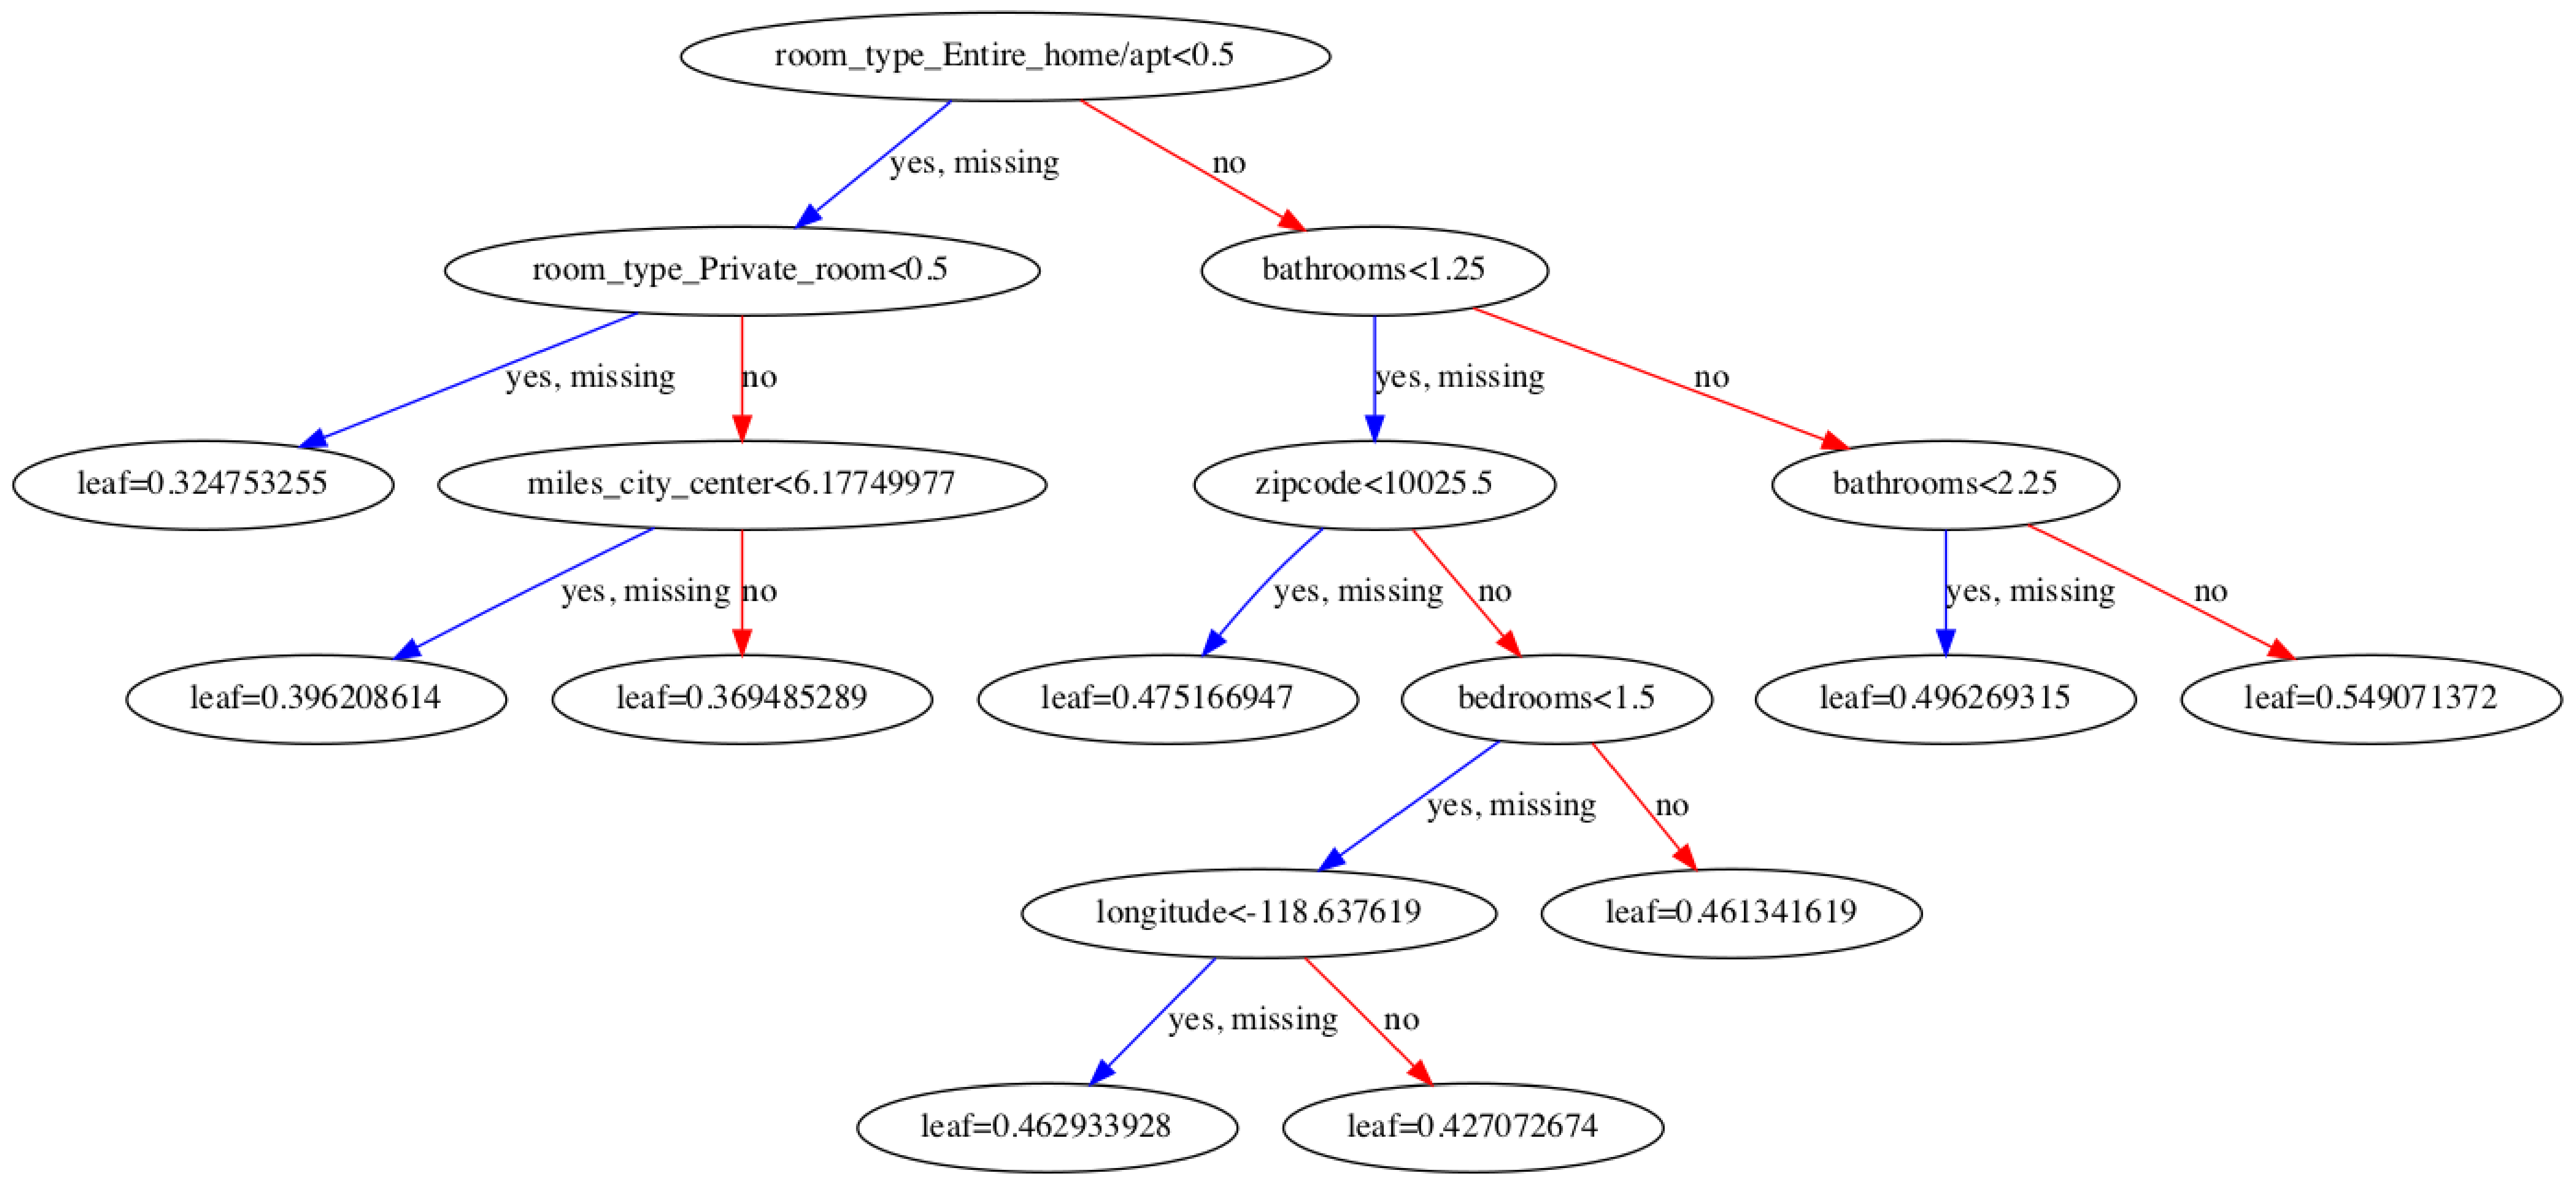

In [199]:
fig, ax = plt.subplots(1,1,figsize=(100,100))
xg_reg = xgb.train(params=params, dtrain=xgtrain, num_boost_round=10)
xgb.plot_tree(xg_reg,num_trees=0, ax=ax)
plt.show()

### Plotting feature importances

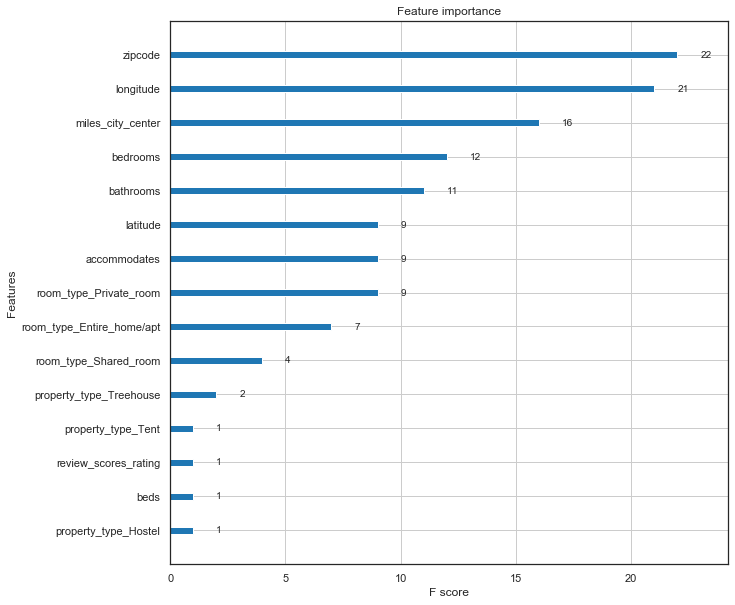

In [205]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(xg_reg, max_num_features=20, ax=ax)
plt.show()

[Text(0, 0.5, 'Residual / Variance / Error'), Text(0.5, 0, 'Actual Prices')]

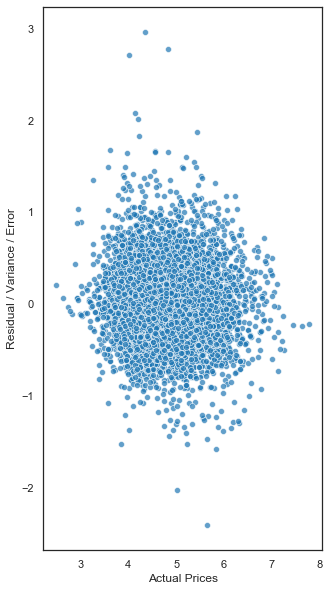

In [217]:
y_scatter  = y_test - preds
ax = sns.scatterplot(preds, y_scatter, alpha=0.7)
ax.set(xlabel='Actual Prices', ylabel='Residual / Variance / Error')


[Text(0, 0.5, 'Predicted Prices'), Text(0.5, 0, 'Actual Prices')]

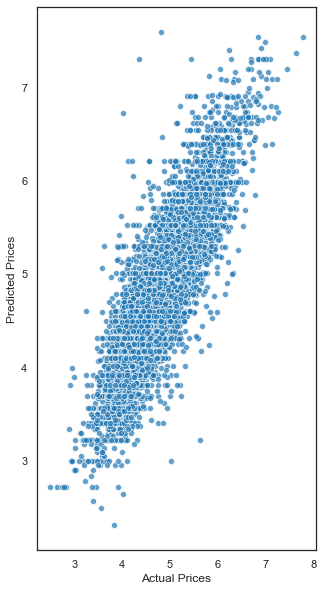

In [216]:
ax = sns.scatterplot(preds, y_test, alpha=0.7)
ax.set(xlabel='Actual Prices', ylabel='Predicted Prices')
